### Importing the necessary libraries

In [18]:
import os
import librosa
import numpy as np
import pandas as pd
import gc # Garbage collector
import psutil
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# GPU memory growth setup (with error handling)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # GPU is available
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured")
    else:
        print("No GPU found. Running on CPU")
except:
    print("No GPU found. Running on CPU")




No GPU found. Running on CPU


In [19]:
# Define your folder structure
data_dir = "/Users/titusmasike/Documents/soft_stuff/Kaggle/music_genre_classification/data/genres_original"
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
random_file_name = "/Users/titusmasike/Documents/soft_stuff/Kaggle/music_genre_classification/data/genres_original/blues/blues.00000.wav"

In [20]:
def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info().rss / (1024 ** 2)  # Convert to MB
    return f"Memory Usage: {memory_info:.2f} MB"

def print_memory_usage(message=""):
    process = psutil.Process(os.getpid())
    memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
    print(f"{message} Memory Usage: {memory:.2f} MB")
    
def clear_memory():
    gc.collect() # Force garbage collection
    print_memory_usage("After cleanup")
    
def get_memory_limit():
    # Get total system memory in bytes
    total_memory = psutil.virtual_memory().total / (1024 ** 2)
    # Set limit to 50% of total memory
    return total_memory / 2

# Limit memory usage
import resource

try:
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    memory_limit = get_memory_limit()
    print(f"Setting memory limit to {memory_limit} MB")
    resource.setrlimit(resource.RLIMIT_AS, (int(memory_limit), hard))
    
    print(f"Memory limit set to {memory_limit} MB")
except Exception as e:
    print(f"Could not set memory limit: {e}")
    print(f"Continuing without memory limit...")


Setting memory limit to 8192.0 MB
Could not set memory limit: current limit exceeds maximum limit
Continuing without memory limit...


Before loading: Memory Usage: 798.89 MB
After loading: Memory Usage: 816.86 MB


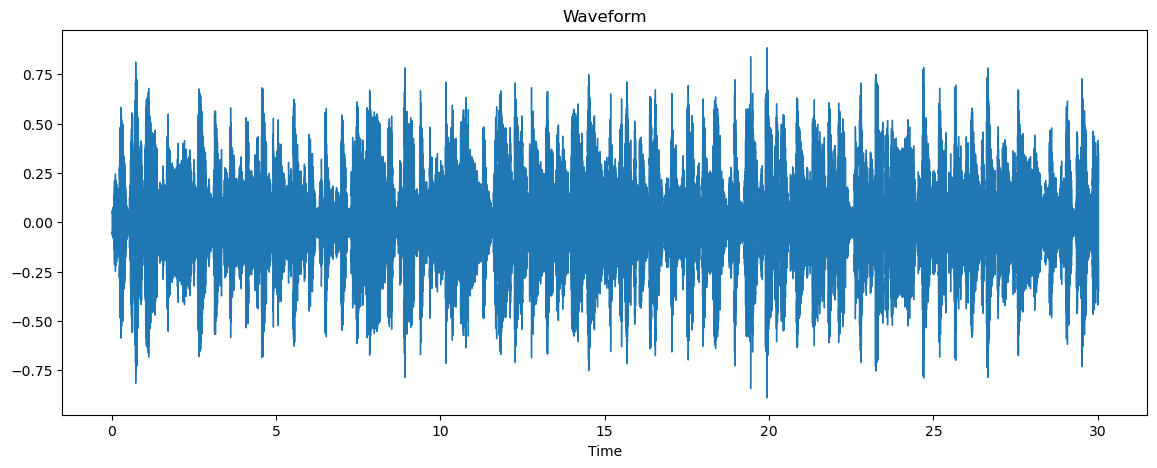

After cleanup Memory Usage: 1152.03 MB


In [21]:
try:
    print_memory_usage("Before loading:")
    x, sr = librosa.load(random_file_name, sr= 44100)
    print_memory_usage("After loading:")
    
    # Create plot
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    plt.title("Waveform")
    plt.show()
    
    # Clear the plot from memory
    plt.close()
    gc.collect()    
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    clear_memory()

### Visualising Single Audio


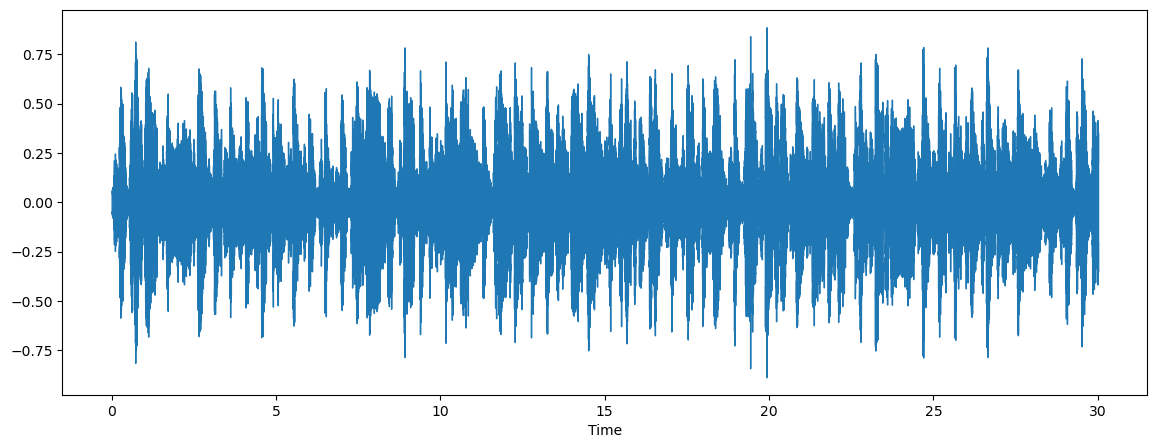

In [22]:

if os.path.exists(random_file_name):
    x, sr = librosa.load(random_file_name, sr= 44100)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
else:
    print(f"File {random_file_name} does not exist.")


### Playing Sound

In [23]:

Audio(data=x, rate=sr)

### Doing visualisation on chunks of audio

Using chunks instead of the entire audio is a good idea because it allows us to process the audio in smaller, more manageable pieces. This can be particularly useful for training deep learning models, as it allows for more efficient use of computational resources and can help prevent overfitting. The entire audio looks closer to noise so it will be easier to train the model on chunks so it can understand the patterns in the audio.

In [24]:
audio_path = "/Users/titusmasike/Documents/soft_stuff/Kaggle/music_genre_classification/data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(audio_path, sr= 44100)

# Define the duration of each chunk and overlap

#chunk_duration = 4 # seconds
#overlap_duration = 2 # seconds

# Convert durations to samples
#chunk_samples = chunk_duration * sr
#overlap_samples = overlap_duration * sr

# Calculate the number of chunks
#num_chunks = int(np.ceil((len(y)) - chunk_samples) / (chunk_samples - overlap_samples)) + 1 

# Iterate over each chunk
#for i in range(num_chunks):
    # Calculate start and end indices of the chunk
    #start = i * (chunk_samples - overlap_samples)
    #end = start + chunk_samples
    
    # Extract the chunk of audio
    #chunk = y[start:end]
    
    # Plot the chunk
    #plt.figure(figsize=(8, 3))
    #librosa.display.waveshow(chunk, sr=sr)
    #plt.title(f"Chunk {i+1}")
    #plt.show()


### Melspectrogram Visualisation

In [25]:
# Plotting Melspectrogram of Entire Audio

def plot_melspectrogram(y,sr):
    # Compute spectogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Visualise the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Melspectrogram')
    plt.tight_layout()
    plt.show()
    
def plot_melspectrogram_chunks(y,sr):
    # define the duration of each chunk and overlap
    chunk_duration = 4 # seconds
    overlap_duration = 2 # seconds
    
    # convert durations to samples
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr
    
    # calculate the number of chunks
    num_chunks = int(np.ceil((len(y)) - chunk_samples) / (chunk_samples - overlap_samples)) + 1 
    
    # iterate over each chunk
    for i in range(num_chunks):
        # Calculate start and end indices of the chunk
        start = i * (chunk_samples - overlap_samples)
        end = start+chunk_samples
        
        # Extract the chunk audio
        chunk = y[start:end]
        
        # Melspectogram part
        
        spectogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        print(spectogram.shape)
        spectrogram_db = librosa.power_to_db(spectogram, ref=np.max)
        
        # Visualise the spectrogram
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Melspectrogram - Chunk {i+1}')
        plt.tight_layout()
        plt.show()


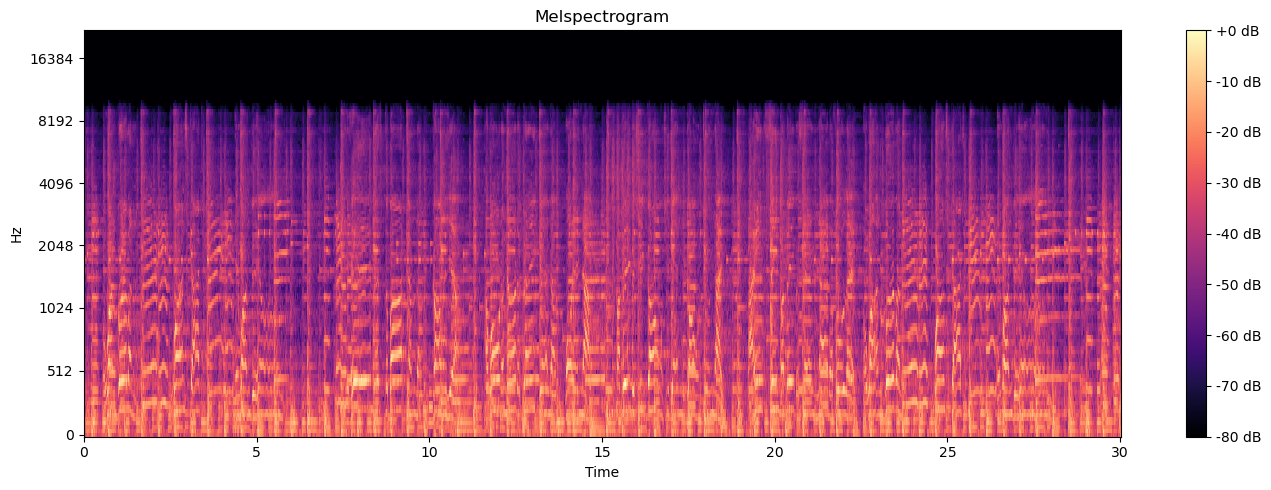

(128, 344)


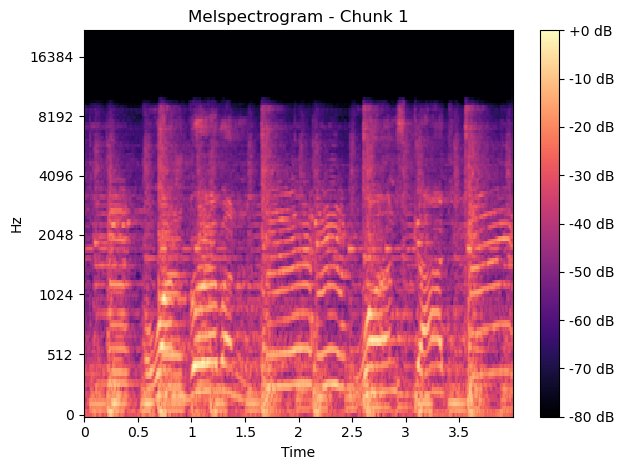

(128, 344)


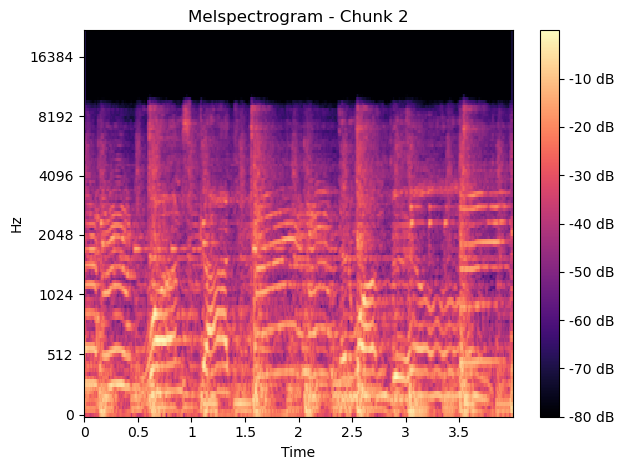

(128, 344)


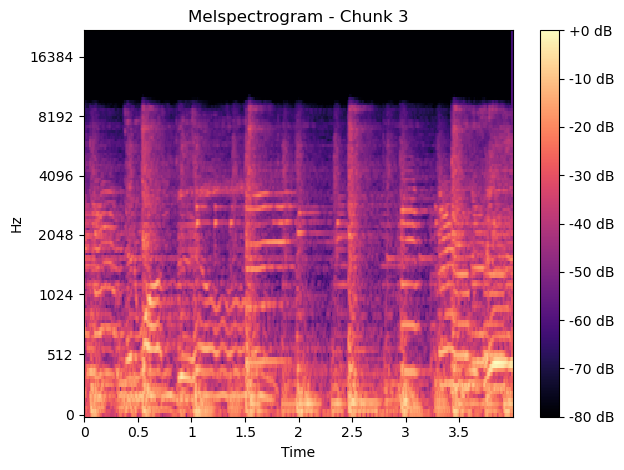

(128, 344)


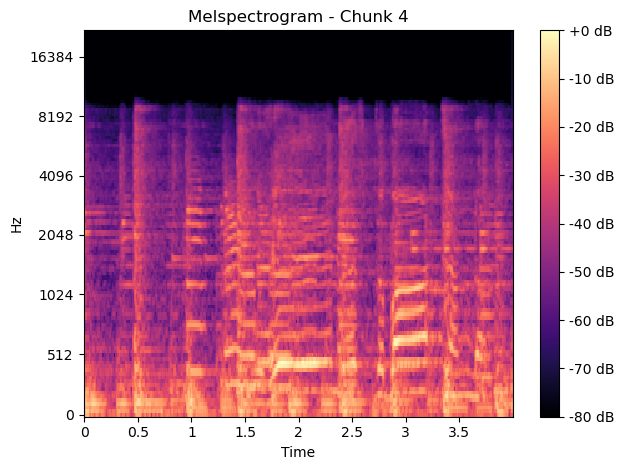

(128, 344)


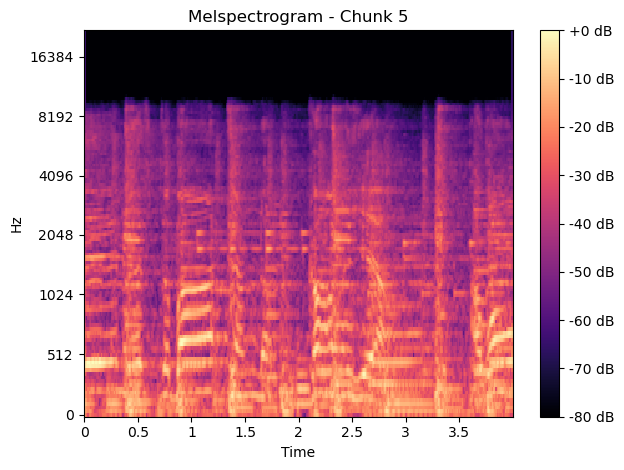

(128, 344)


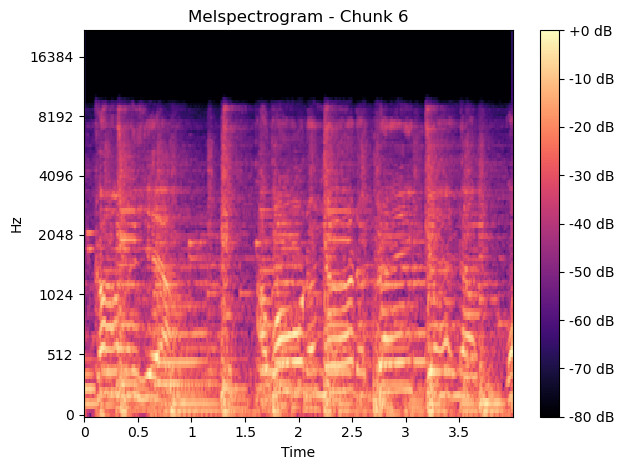

(128, 344)


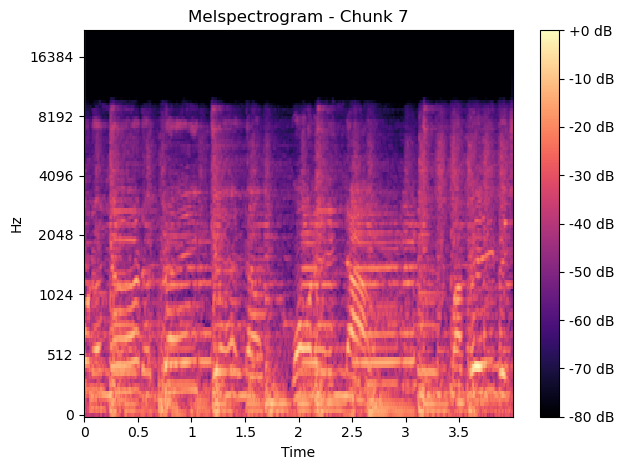

(128, 344)


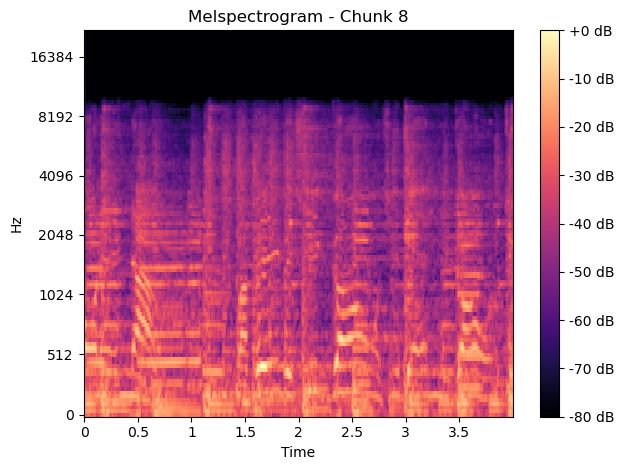

(128, 344)


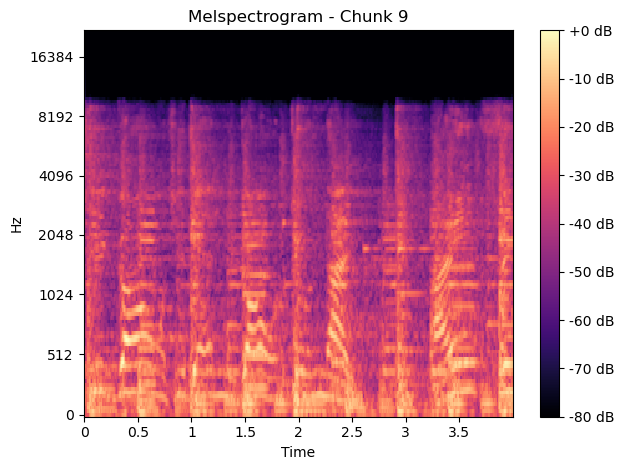

(128, 344)


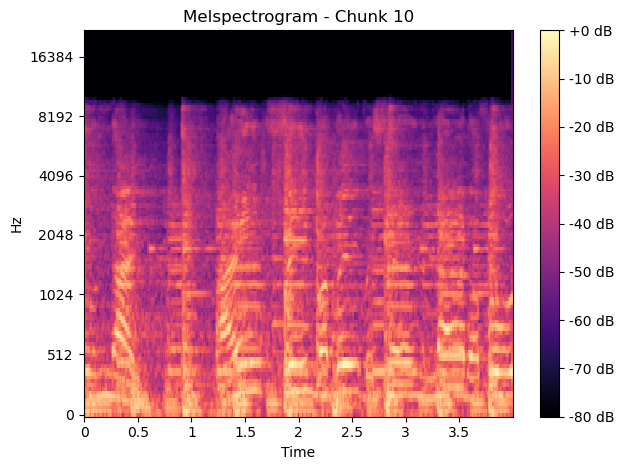

(128, 344)


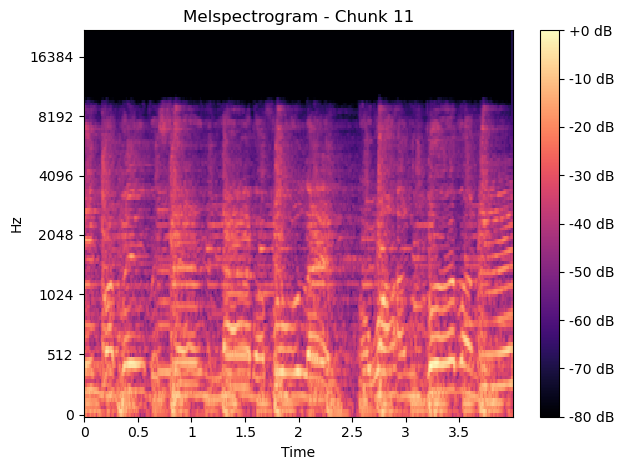

(128, 344)


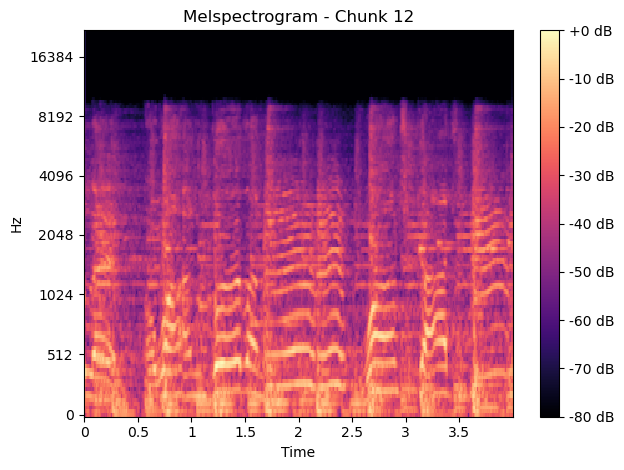

(128, 344)


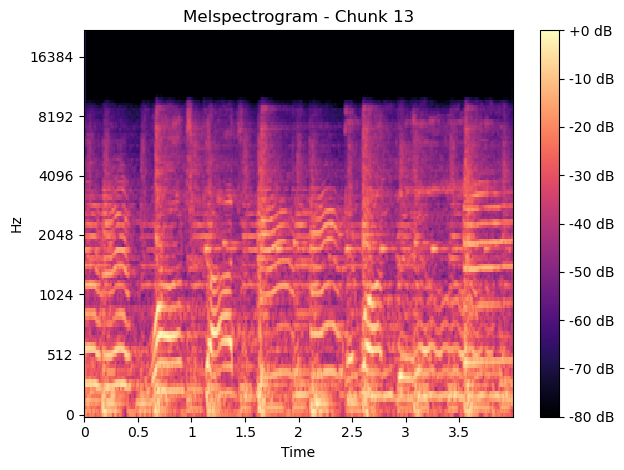

(128, 344)


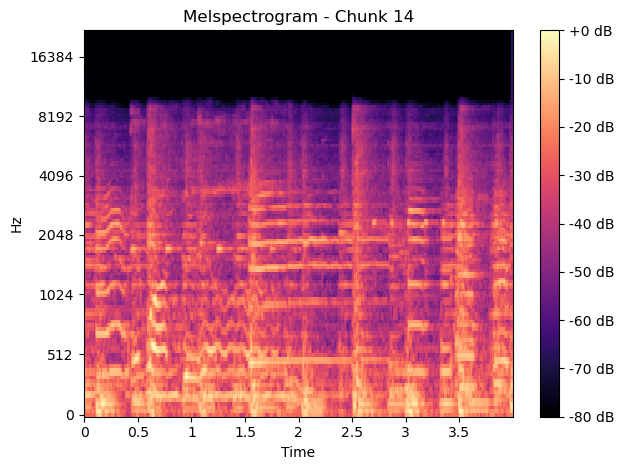

In [26]:
y, sr = librosa.load(random_file_name, sr= 44000)
plot_melspectrogram(y, sr)
plot_melspectrogram_chunks(y, sr)

### Problems with entire audio Melspectrogram

It is way too noisy and it is hard to see distinct patterns in the audio in order for it to classify the genre, let alone classify the specific genre you want to listen to. Our neural network will have a hard time classifying the genre because it will be too noisy. Now we are going to go into datapreprocessing

In [27]:

def process_single_file(file_path, sample_rate, i_class, target_shape=(150, 150), chunk_duration=4, overlap_duration=2):
    data = []
    labels = []
    try:
        # Load audio file
        audio_data, sr = librosa.load(file_path, sr=sample_rate)
        
        # Calculate chunk parameters
        chunk_samples = chunk_duration * sr
        overlap_samples = overlap_duration * sr
        
        # Calculate the number of chunks
        num_chunks = int(np.ceil((len(audio_data) - chunk_samples))/(chunk_samples-overlap_samples)) + 1
        
        # Iterate over each chunk
        for i in range(num_chunks):
            # Calculate start and end indices of the chunk
            start = i*(chunk_samples-overlap_samples)
            end = start+chunk_samples
            
            # Extract the chunk audio
            chunk = audio_data[start:end].copy()
            
            # Pad if necessary (DO THIS BEFORE MEL SPECTROGRAM)
            if len(chunk) < chunk_samples:
                chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), mode='constant')
            
            # Melspectrogram part
            mel_spectrogram = librosa.feature.melspectrogram(
                y=chunk, 
                sr=sample_rate,
                n_fft=2048,
                hop_length=512,
                n_mels=128
            )
            
            # convert to log scale (This is done to make the data more readable and to make the data more suitable for training the model)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            
            # Resize the matrix based on provided target shape
            mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=1), target_shape)
            
            # Append data and label to list together
            data.append(mel_spectrogram)
            labels.append(i_class)
            
            del chunk # Free memory
            gc.collect()
            
            
        return data, labels # Return both data and label
    
    except Exception as e:
        print(f"Error processing audio data: {str(e)}")
        return None, None
    


In [28]:
def process_single_genre(class_dir, sample_rate, class_name, i_class, max_files=20, target_shape=(150, 150), chunk_duration=4, overlap_duration=2, batch_size=5):
    """ Process a single genre in batches and limitied files"""
    
    # Get list of files
    files = [f for f in os.listdir(class_dir) if f.endswith('.wav')][:max_files]
    
    for i in range(0, len(files), batch_size):
        batch_files = files[i:i+batch_size]
        batch_data = []
        batch_labels = []
        
        for j, file in enumerate(batch_files):
            try:
                file_path = os.path.join(class_dir, file)
                print(f"\nProcessing {class_name} - File {i+j+1}/{len(files)}: {file}")

                # Process single file
                data, labels = process_single_file(
                    file_path, 
                    sample_rate, 
                    i_class, 
                    target_shape, 
                    chunk_duration, 
                    overlap_duration
                )
                if data is not None:
                    batch_data.extend(data)
                    batch_labels.extend(labels)
                    
            except Exception as e:
                print(f"Error loading audio file {file}: {e}")
                continue
                
        if batch_data:
            # Convert to float32 but maintain precision
            yield np.array(batch_data, dtype=np.float32), np.array(batch_labels)
                
            
        # Clear batch data and labels
        del batch_data
        del batch_labels
        gc.collect()
        print(f"After batch size of {batch_size} files processed {get_memory_usage()}")


In [29]:
def load_and_process_data(data_dir, classes, sample_rate=22050, batch_size=5,max_files=20,chunk_duration=4,overlap_duration=2,target_shape=(150, 150)):
    try:
        all_data = []
        all_labels = []
        
        # Process one genre at a time
        for i_class, genre in enumerate(classes[:5]):
            print(f"\nProcessing genre: {genre}")
            print_memory_usage("Before genre processing")
        
            class_dir = os.path.join(data_dir, genre)
            
            try:
                for batch_data, batch_labels in process_single_genre(
                    class_dir=class_dir,
                    sample_rate=sample_rate,
                    class_name=genre,
                    i_class=i_class,
                    max_files=max_files,
                    target_shape=target_shape,
                    chunk_duration=chunk_duration,
                    overlap_duration=overlap_duration,
                    batch_size=batch_size
                ):
                    all_data.extend(batch_data)
                    all_labels.extend(batch_labels)
                
                print_memory_usage("After genre processing")
                gc.collect()

            except Exception as e:
                print(f"An error occurred while processing genre {genre}: {e}")
                continue
                
        # Convert to numpy arrays
        if all_data and all_labels:
            data = np.array(all_data)
            labels = np.array(all_labels)
    
            print("\nProcessing complete!")
            print("Shape of processed data:", data.shape)
            print("Shape of labels:", labels.shape)
            
            return data, labels
        else:
            raise ValueError("No data or labels were processed.")
        
        
    except Exception as e:
        print(f"An error occurred: {e}")
        raise
    finally:
        gc.collect()
        print_memory_usage("Final memory usage")
            

### Issues with attempting to train this model

- Model is quite large and takes a long time to train
- You have to create algorithms to handle the memory usage
- By creating the algorithms to handle the memory usage, you will have to create a lot of code to handle the memory usage, which will make the code more complex but it is good practise for future projects

In [30]:
#data, labels = load_and_process_data(data_dir, classes, sample_rate=11025, batch_size=2,max_files=50,chunk_duration=4,overlap_duration=2,target_shape=(150, 150))
#print("\nData shape: ", data.shape)
#print("\nLabels shape: ", labels.shape)

In [31]:
# Save the data and labels to a pickle file

def save_data(data, labels):
    try:
        with open('processed_music_data.pkl', 'wb') as f:
            pickle.dump({'data': data,
                    'labels': labels
                    }, f)
        print("Data and labels saved to pickle file")   
    except Exception as e:
        print(f"An error occurred: {e}")
        raise
    

# Load the data and labels from the pickle file
def load_data():
    try:
        with open('processed_music_data.pkl', 'rb') as f:
            saved_data = pickle.load(f)
            data = saved_data['data']
            labels = saved_data['labels']
            print("Data and labels loaded from pickle file")
            return data, labels
    except Exception as e:
        print(f"An error occurred: {e}")
        raise
    


In [32]:
#save_data(data, labels)

My computer, where I'm creating the model, has insufficient memory and as a result I had to create the spectrograms in batches so that i can balance the computational power of my laptop and with the magnitude of the files sizes of the .wav files I need to extract the information from.

## Splitting of Dataset into Training and Test set

In [33]:

#X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

## Building the model

In [ ]:
# Clear memory first
import gc
tf.keras.backend.clear_session()
gc.collect()

try:
    # Load saved data
    print("Loading data...")
    data, labels = load_data()
    
    labels = to_categorical(labels, num_classes = len(classes)) # Converting labels to one-hot encoding
    
    X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)
    
    # Free memory
    del data
    del labels
    gc.collect()
    
    # Take a very small subset first
    X_train_tiny = X_train[:500]  
    Y_train_tiny = Y_train[:500]
    
    X_test_tiny = X_test[:100]
    Y_test_tiny = Y_test[:100]
    
    # Normalize the data
    X_train_tiny = X_train_tiny.astype('float32')
    X_train_tiny = (X_train_tiny - np.mean(X_train_tiny)) / np.std(X_train_tiny)
    X_test_tiny = X_test_tiny.astype('float32')
    X_test_tiny = (X_test_tiny - np.mean(X_test_tiny)) / np.std(X_test_tiny)
    
    # Reshape labels if needed
    if len(Y_train_tiny.shape) > 2:
        Y_train_tiny = Y_train_tiny.reshape(Y_train_tiny.shape[0], -1)[:,:10]
    
    
    print("\nFinal Shapes:")
    print("X_train_tiny:", X_train_tiny.shape)
    print("Y_train_tiny:", Y_train_tiny.shape)
    
    # Create minimal augmentation
    datagen = ImageDataGenerator(
        validation_split=0.2, # 20% of the data is used for validation
        width_shift_range=0.1, # two simple time shift augmentations
        height_shift_range=0.1, # frequency shift augmentation
        #rotation_range=5, # rotation augmentation
        rescale=1./255, # normalise the data
        
    )
    
    # Prepare generators
    train_generator = datagen.flow(
        X_train_tiny, Y_train_tiny, 
        batch_size=8,
        subset='training',
        shuffle=True
    )
    
    #val_generator = datagen.flow(
    #    X_test_tiny, Y_test_tiny,
    #    batch_size=16,
    #    subset='validation',
    #    shuffle=True
    #)
    
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3,3), padding='same',activation='relu',input_shape=(150,150,87)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)), 
        Dropout(0.25), # Light dropout to prevent overfitting
        
        # Second Conv Block
        Conv2D(64, (3,3), padding='same', activation='relu'),
        #Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25), # Light dropout to prevent overfitting
        
        # Third Conv Block
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        #Dropout(0.4),
        
        
        # Dense layers
        GlobalAveragePooling2D(), # This will dramatically reduce parameters
        Dense(128,activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(units=len(classes),activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Higher learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Add class weights to handle imbalance if any
    class_weights = dict(enumerate(np.ones(len(classes))))  # Start with equal weights
    
    # Try training with minimal data
    history = model.fit(
        X_train_tiny,
        Y_train_tiny,
        epochs=30,  
        batch_size=8,  # Very small batch size
        validation_split=0.2,
        #shuffle=True,
        verbose=1,
        class_weight=class_weights,
        validation_data=(X_test_tiny, Y_test_tiny),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', 
                patience=8, 
                restore_best_weights=True,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5, # More aggressive learning rate reduction
                patience=2,
                min_lr=0.000001
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',
                save_best_only=True,
                monitor='val_loss'
            )
        ]
    )
    
    print("Training successful!")
    
except Exception as e:
    print(f"Error occurred: {str(e)}")
finally:
    # Clean up memory
    gc.collect()

### Save the Model and History

In [ ]:
# Save the trained model

try:
    model.save("music_genre_classifier.keras") #Mac

# Save the training history as JSON
    history_dict = {}
    for key in history.history.keys():
        history_dict[key] = [float(x) for x in history.history[key]]

    with open('training_history.json', 'w') as f:
        json.dump(history_dict, f)
    
    model.save_weights('model_weights.weights.h5')
    
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    predictions = model.predict(X_test_tiny)
    model_data = {
        'predictions': predictions,
        'history': history.history,
        'test_accuracy': model.evaluate(X_test_tiny, Y_test_tiny)[1]
    }
    
    with open('model_data.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print("Model and history saved successfully!")

except Exception as e:
    print(f"Error occurred: {str(e)}")



### Load the Model and History

In [ ]:
try:
    # load the saved model
    loaded_model = tf.keras.models.load_model("music_genre_classifier.keras", compile=False)

    # Recompile the model
    loaded_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    # Load JSON history
    with open('training_history.json', 'r') as f:
        history_json = json.load(f)
    
    # Load pickle history
    with open('training_history.pkl', 'rb') as f:
        history_pkl = pickle.load(f)
    
    # load model data
    with open('model_data.pkl', 'rb') as f:
        model_data = pickle.load(f)
    
    print("Model and history loaded successfully!")

    # Accessing the model data
    predictions = model_data['predictions']
    test_accuracy = model_data['test_accuracy']
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    


In [ ]:
# Reloading model variable
loaded_model.summary()

In [34]:
data, labels = load_data()
    
labels = to_categorical(labels, num_classes = len(classes)) # Converting labels to one-hot encoding
    
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

# Take a very small subset first
X_train_tiny = X_train[:500]  
Y_train_tiny = Y_train[:500]
    
X_test_tiny = X_test[:100]
Y_test_tiny = Y_test[:100]
    
# Normalize the data
#X_train_tiny = X_train_tiny.astype('float32')
#X_train_tiny = (X_train_tiny - np.mean(X_train_tiny)) / np.std(X_train_tiny)
#X_test_tiny = X_test_tiny.astype('float32')
#X_test_tiny = (X_test_tiny - np.mean(X_test_tiny)) / np.std(X_test_tiny)

: 

In [ ]:
# Model Evaluation on Training set
train_loss, train_accuracy = loaded_model.evaluate(X_train_tiny, Y_train_tiny, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Model Evaluation on Test set

In [ ]:
val_loss,val_accuracy = loaded_model.evaluate(X_test_tiny, Y_test_tiny, verbose=0)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}")


In [ ]:
history['val_loss']

### Accuracy and Loss Visualisation

In [ ]:
# Visualisation of Loss and Accuracy
epochs = range(1, len(history['loss']) + 1)

plt.plot(epochs, history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Visualisation of Accuracy
plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Precision, Recall, Confusion Matrix - Model Evaluation II

In [ ]:
X_test_tiny.shape

In [ ]:
y_pred = model.predict(X_test_tiny)
print(f"y_pred: {y_pred.shape}")

In [ ]:
predicted_categories = np.argmax(y_pred, axis=1)
print(f"predicted_categories: {predicted_categories.shape}")



In [ ]:
Y_test_tiny.shape

In [ ]:
true_categories = np.argmax(Y_test_tiny, axis=1)
print(f"true_categories: {true_categories.shape}")



In [ ]:
print(f"Classes: {classes}")



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

In [ ]:
## Confusion Matrix Visualisation

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()